# Uplift prediction on the Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset using the CausalML package

## Introduction

The Hillstrom's MineThatData E-Mail Analytics And Data Mining Challenge dataset contains 64,000 customers involved in an e-mail campaign.
The customers are randomly divided into three equal groups:

* the first group receives an e-mail campaign on Mens merchandise;
* the second group receives an e-mail campaign on Womens merchandise;
* the third group does not receive any campaign.

Since the customers receiving a treatment have the same probability of belonging to one of the three segments, the propensity score is known.

In this test we consider only one e-mail campaign at a time, therefore we exclude the individuals having received the other treatment.
This means that the propensity score of each customer is 0.5.

## Meta-Learners

In this first test, we use the Meta-Learners from the CausalML package. In particular, we use:

* S-Learner
* T-Learner
* X-Learner with propensity score
* R-Learner with propensity score

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score

%matplotlib inline

In [8]:
from datasets import HillstromDataset

### Loading the data

We choose which campaign to analyze by changing the *campaign* parameter of *getCampaignData*. By choosing 1, we target
the Mens campaign, while by choosing 2 we target the Womens campaign.

We define the following vectors:
* y, the outcome
* X, the features
* w, the treatment indicator
* p, the propensity score

In [9]:
data = HillstromDataset()
y, X, w = data.getCampaignData(campaign=1)
p = np.full(shape=y.size, fill_value=0.5)

### CATE estimation

We initialize our Meta-Learners using a Linear Regression model and we estimate the CATE.

In [10]:
# S Learner
learner_s = BaseSRegressor(learner=LinearRegression())
cate_s = learner_s.fit_predict(X=X, treatment=w, y=y)

# T Learner
learner_t = BaseTRegressor(learner=LinearRegression())
cate_t = learner_t.fit_predict(X=X, treatment=w, y=y)

# X Learner with propensity score input
learner_x = BaseXRegressor(learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=w, y=y, p=p)

# R Learner with propensity score input
learner_r = BaseRRegressor(learner=LinearRegression())
cate_r = learner_r.fit_predict(X=X, treatment=w, y=y, p=p)

### Uplift curve

We plot the uplift curve by using the dedicated function from the CausalML package. We estimate the area under the curve
to compare the different models.

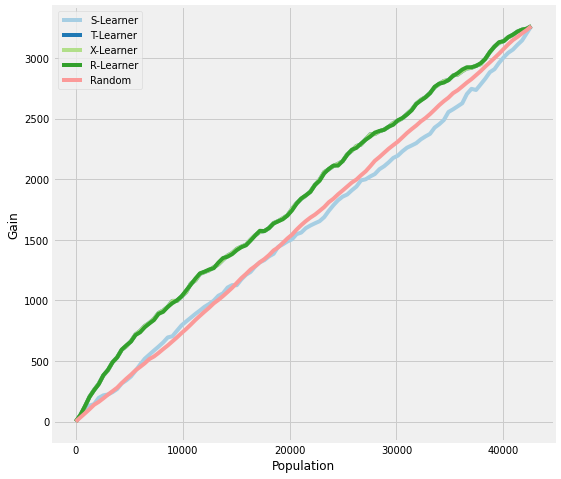

In [11]:
df = pd.DataFrame({'y': y, 'w': w, 'S-Learner': cate_s.flatten(),
                   'T-Learner': cate_t.flatten(), 'X-Learner': cate_x.flatten(), 'R-Learner': cate_r.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

In [12]:
auuc_score(df, outcome_col='y', treatment_col='w')

S-Learner    0.486002
T-Learner    0.562090
X-Learner    0.562090
R-Learner    0.562105
Random       0.498296
dtype: float64